In [12]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MaxAbsScaler
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, GPT2Config, AdamW
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score

In this Jupyter Notebook, we are building a model to predict the movement of the Dow Jones Industrial Average (DJIA) based on daily news headlines. 

We start by importing necessary libraries and modules. These include numpy for numerical operations, pandas for data manipulation, sklearn for preprocessing and model selection, torch for deep learning, transformers for the GPT-2 model, and tqdm for progress bars.

Next, we load and preprocess the dataset. The dataset is a CSV file named 'Combined_News_DJIA.csv'. Each record in the dataset consists of the date, the DJIA label (1 for increase, 0 for decrease), and 25 top news headlines for the day. We concatenate all the news headlines into a single string for each record.

We then split the dataset into a training set and a validation set using a 80-20 split.

In [13]:
# Load and preprocess the dataset
data = pd.read_csv('Datasets/Combined_News_DJIA.csv')

# Concatenate all the news headlines into a single string for each record
# Optimized by directly using pandas functionality
data['All_Headlines'] = data.iloc[:, 2:].fillna('').apply(lambda x: ' '.join(x), axis=1)
train_df, val_df = train_test_split(data, test_size=0.2, random_state=42)

We define a custom Dataset class for tokenization and batching. This class takes in the headlines and labels, tokenizes the headlines using the GPT-2 tokenizer, and returns the input IDs, attention masks, and labels for each batch.

In [14]:
# Define a custom Dataset class for tokenization and batching
class NewsDataset(Dataset):
    def __init__(self, headlines, labels, tokenizer, max_len):
        self.headlines = headlines
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.headlines)
    
    def __getitem__(self, item):
        headline = str(self.headlines[item])
        label = self.labels[item]
        
        encoding = self.tokenizer.encode_plus(
            headline,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'headline_text': headline,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

We create data loaders for batch processing. These data loaders take in a dataframe, a tokenizer, a maximum length for the headlines, and a batch size, and return a DataLoader object that can be used for training and evaluation.

In [15]:
# Create data loaders for batch processing
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = NewsDataset(
        headlines=df['All_Headlines'].to_numpy(),
        labels=df['Label'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(ds, batch_size=batch_size, num_workers=0)

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # Use EOS token as pad token

MAX_LEN = 128
BATCH_SIZE = 16

model = GPT2ForSequenceClassification.from_pretrained('gpt2', num_labels=2)
model.config.pad_token_id = model.config.eos_token_id  # Configuring pad token
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

train_data_loader = create_data_loader(train_df, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


We initialize the GPT-2 model for sequence classification with two labels, move it to the GPU if available, and define the AdamW optimizer for training. 

The code below defines a function called train_epoch that performs training and evaluation on a machine learning model using a given data loader. It iterates over the data loader, computes the model's outputs, calculates the loss, updates the model's parameters through backpropagation, and returns the accuracy and average loss for the epoch.

In [16]:
# Training function with model evaluation on validation data
def train_epoch(model, data_loader, optimizer, device, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    
    for d in tqdm(data_loader, desc="Training"):
        input_ids = d['input_ids'].to(device)
        attention_mask = d['attention_mask'].to(device)
        labels = d['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        logits = outputs.logits
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    return correct_predictions.double() / n_examples, np.mean(losses)

The code below is a training loop with early stopping for a machine learning model. It trains the model for a specified number of epochs and evaluates its performance on a validation dataset after each epoch. If the validation accuracy improves, the model's state is saved as the best model so far. If the validation accuracy does not improve for a certain number of epochs (defined by the early stopping limit), the training loop is stopped and the best model is reloaded. The code also includes the implementation of the train_epoch function, which performs one training epoch for the model using a data loader.

In [19]:
# Define the eval_model function here
def eval_model(model, data_loader, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)


In [20]:
# Set the number of epochs for training
EPOCHS = 10

# Initialize the best validation accuracy to 0
best_val_accuracy = 0

# Initialize the early stopping counter to 0
early_stopping_counter = 0

# Set the limit for early stopping
early_stopping_limit = 3

# Start the training loop
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    # Train the model for one epoch and get the training accuracy and loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        len(train_df)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')

    # Evaluate the model on the validation data and get the validation accuracy and loss
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        len(val_df)
    )
    print(f'Val loss {val_loss} accuracy {val_acc}')

    # If the validation accuracy is better than the best so far, save the model's state and reset the early stopping counter
    if val_acc > best_val_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_val_accuracy = val_acc
        early_stopping_counter = 0
    else:
        # If the validation accuracy did not improve, increment the early stopping counter
        early_stopping_counter += 1

    # If the early stopping counter exceeds the limit, stop training and load the best model's state
    if early_stopping_counter > early_stopping_limit:
        print("Early stopping, reloading checkpoint model")
        model.load_state_dict(torch.load('best_model_state.bin'))
        break

Epoch 1/10
----------


Training: 100%|██████████| 100/100 [03:47<00:00,  2.28s/it]


Train loss 0.687165886759758 accuracy 0.5537397862979259
Val loss 0.7180005979537963 accuracy 0.4723618090452261
Epoch 2/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.6530856329202652 accuracy 0.6172218730358265
Val loss 0.7435610342025757 accuracy 0.4849246231155779
Epoch 3/10
----------


Training: 100%|██████████| 100/100 [03:38<00:00,  2.18s/it]


Train loss 0.5784229359030724 accuracy 0.7020741671904462
Val loss 0.8035862565040588 accuracy 0.4824120603015075
Epoch 4/10
----------


Training: 100%|██████████| 100/100 [03:37<00:00,  2.18s/it]


Train loss 0.44692241862416265 accuracy 0.7944688874921433
Val loss 0.8707500100135803 accuracy 0.4899497487437186
Epoch 5/10
----------


Training: 100%|██████████| 100/100 [03:36<00:00,  2.17s/it]


Train loss 0.2690195171907544 accuracy 0.8975487115021998
Val loss 1.0900764107704162 accuracy 0.4899497487437186
Epoch 6/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.15s/it]


Train loss 0.15249558406881988 accuracy 0.950345694531741
Val loss 1.1220964288711548 accuracy 0.5
Epoch 7/10
----------


Training: 100%|██████████| 100/100 [03:35<00:00,  2.15s/it]


Train loss 0.08793571271002293 accuracy 0.9824010056568196
Val loss 1.5177232837677002 accuracy 0.4798994974874372
Epoch 8/10
----------


Training: 100%|██████████| 100/100 [03:34<00:00,  2.14s/it]


Train loss 0.05843898297753185 accuracy 0.9880578252671276
Val loss 1.5878902220726012 accuracy 0.46984924623115576
Epoch 9/10
----------


Training: 100%|██████████| 100/100 [03:33<00:00,  2.14s/it]


Train loss 0.04322270812932402 accuracy 0.9905719673161534
Val loss 1.6578028035163879 accuracy 0.46733668341708545
Epoch 10/10
----------


Training: 100%|██████████| 100/100 [03:50<00:00,  2.31s/it]


Train loss 0.034880156663712115 accuracy 0.9918290383406663
Val loss 1.8640478682518005 accuracy 0.45979899497487436
Early stopping, reloading checkpoint model


In [25]:
# Evaluation function and accuracy calculation
def evaluate(model, data_loader, device):
    # Set the model to evaluation mode
    model.eval()
    
    # Initialize lists to store predictions and real values
    predictions = []
    real_values = []

    # Disable gradient calculations
    with torch.no_grad():
        # Iterate over batches from the data loader
        for d in data_loader:
            # Move input and attention mask to device
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            
            # Get model outputs
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            # Get the predicted class with the highest probability
            _, preds = torch.max(outputs.logits, dim=1)
            
            # Add the predictions and real values to their respective lists
            predictions.extend(preds)
            real_values.extend(d["labels"])
    
    # Convert lists to tensors and move them to CPU
    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    
    # Return predictions and real values
    return predictions, real_values

Balanced Accuracy Score (Validation): 0.5082953345183812


## Evaluation

Evaluation Report seeing balanced accuracy score, and test accuracy

In [30]:
from sklearn.metrics import accuracy_score, classification_report

# Load the best saved model (if early stopping occurred)
model.load_state_dict(torch.load('best_model_state.bin'))

# Test the best model to get the final classification report and accuracy
test_predictions, test_real_values = evaluate(model, val_data_loader, device)
print(classification_report(test_real_values, test_predictions))
print("Test Accuracy:", accuracy_score(test_real_values, test_predictions))

# Calculate the balanced accuracy score
val_predictions, val_real_values = evaluate(model, val_data_loader, device)

# Calculate and print the balanced accuracy score for the entire validation set
balanced_accuracy_val = balanced_accuracy_score(val_real_values.numpy(), val_predictions.numpy())
print("Balanced Accuracy Score (Validation):", balanced_accuracy_val)

              precision    recall  f1-score   support

           0       0.44      0.57      0.49       171
           1       0.58      0.45      0.51       227

    accuracy                           0.50       398
   macro avg       0.51      0.51      0.50       398
weighted avg       0.52      0.50      0.50       398

Test Accuracy: 0.5
Balanced Accuracy Score (Validation): 0.5082953345183812


Check examples on actual evaluations

In [27]:
individual_predictions, individual_real_values = evaluate(model, test_data_loader, device)

# Print predictions and actual labels for individual headlines
for i in range(len(individual_predictions)):
    print(f"Headline: {test_sample['All_Headlines'].iloc[i]}")
    print(f"Predicted sentiment: {'Increase' if individual_predictions[i] == 1 else 'Decrease'}")
    print(f"Actual movement: {'Increase' if individual_real_values[i] == 1 else 'Decrease'}")
    print("---")

Headline: b'Greece: Union activist loses her eye in acid attack. Her supporters blockade company. Riot police "forced to run leaving shields, helmets and even shoes behind."' b'Israel has been in violation of international law since 1967, protected by the United States veto of UN Resolutions condemning Israel for its violent, inhumane, barbaric, and illegal acts.' b'Zbigniew Brzezinski to Joe Scarborough on Gaza: "You know, you have such a stunningly superficial knowledge of what went on that it\'s almost embarrassing to listen to you."' b'Iceland after the fall' b'Russia is to shut off gas supplies to Ukraine, raising fears of European energy shortages' b'Video about living conditions in Gaza (from 2007)' b'"Here is a simple, stone cold fact. You cannot read or hear the truth about what is happening in Gaza from any corporate media in the United States."' b'MP wins support to ban topless sunbathing on Aussie beaches' b"The IL Gov scandal is wrong, but almost EVERY election/bill/decisi

We can put in headline here our self and check the predicted result

In [28]:
def predict_headline(model, tokenizer, headline, device, max_len=128):
    model.eval()  # Put the model in evaluation mode

    # Tokenizing the headline
    encoding = tokenizer.encode_plus(
        headline,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Forward pass, get the logits
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

    # Convert logits to probabilities (optional)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)

    # Get the predicted index
    predicted_index = torch.argmax(probabilities, dim=-1).item()
    predicted_probability = probabilities[:, predicted_index].item()

    return {
        'headline': headline,
        'prediction': 'Increase' if predicted_index == 1 else 'Decrease',
        'probability': predicted_probability
    }

# Example of testing an individual headline
headline = "Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns."
result = predict_headline(model, tokenizer, headline, device)
print(f"Headline: {result['headline']}")
print(f"Predicted Movement: {result['prediction']}")
print(f"Prediction Probability: {result['probability']:.2f}")

# Major Bank Faces Regulatory Scrutiny Over Fraud Allegations. Tech Giant's Revenue Plummets Following Weak Quarterly Earnings Report. 
# Global Markets Tumble Amidst Rising Geopolitical Tensions. 
# Investor Confidence Hits New Low as Recession Fears Intensify. Cryptocurrency Exchange Files for Bankruptcy After Cyber Attack. 
# Oil Prices Crash Due to Unexpected Surge in Global Supply. Retail Giant Closes Hundreds of Stores Nationwide Amid Sales Decline. 
# Housing Market Slump Continues as Mortgage Rates Soar. Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns. 
# Start-Up Valuations Plummet as Venture Capital Funding Dries Up.


Headline: Automobile Manufacturer Recalls Millions of Vehicles Over Safety Concerns.
Predicted Movement: Increase
Prediction Probability: 0.94


## Use confusion matrix and ROC curve to visualize result

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.57      0.49       171
           1       0.58      0.45      0.51       227

    accuracy                           0.50       398
   macro avg       0.51      0.51      0.50       398
weighted avg       0.52      0.50      0.50       398

Accuracy Score: 0.5


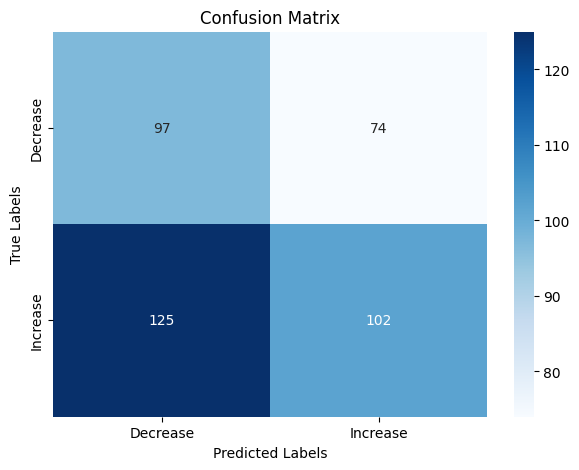

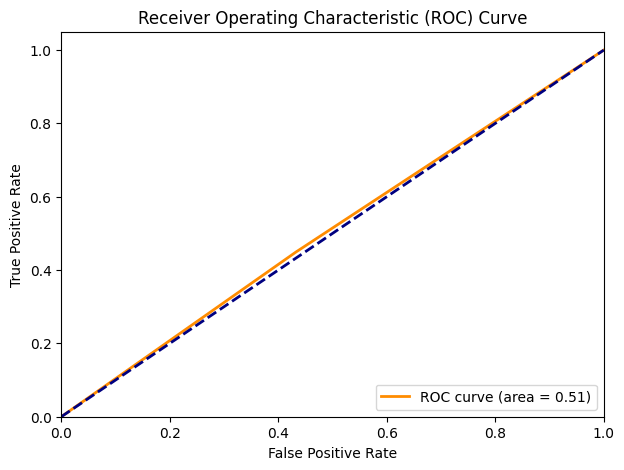

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc

def evaluate_and_visualize(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d['input_ids'].to(device)
            attention_mask = d['attention_mask'].to(device)
            labels = d['labels'].to(device)
            
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            
            _, preds = torch.max(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            real_values.extend(labels.cpu().numpy())
    
    # Evaluation metrics
    print("Classification Report:\n", classification_report(real_values, predictions))
    print("Accuracy Score:", accuracy_score(real_values, predictions))

    # Confusion matrix
    cf_matrix = confusion_matrix(real_values, predictions)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Decrease', 'Increase'], yticklabels=['Decrease', 'Increase'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(real_values, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Prepare the test data loader if not already done
# No need to define test_df, use val_df instead
test_data_loader = create_data_loader(val_df, tokenizer, MAX_LEN, BATCH_SIZE)
  # test_df needs to be defined

# Call the evaluation and visualization function
evaluate_and_visualize(model, test_data_loader, device)


# Some remarks and Next step

The performance of our model has been underwhelming, and we believe there are two primary reasons for this. Firstly, the inherent difficulty of the task cannot be overstated; we are dealing with a variety of daily headlines and the unpredictable nature of stock prices. Notably, our confusion matrix revealed that the model frequently misclassifies instances of stock price increases as decreases. This issue may stem from the general upward trend in stock indices during the training period, suggesting that the model lacks awareness of this long-term growth pattern. We need to explore strategies to incorporate this trend into the model's understanding.

Secondly, the architecture of the model itself might be contributing to the poor results. We are currently using GPT-2, which is primarily a decoder-based model, whereas the nature of our task aligns more closely with the functionalities of an encoder. In light of this, we plan to retrain our system using an encoder-based model like BERT to potentially improve its performance.

Should this adjustment prove effective, our next steps would include implementing inference optimization techniques we've studied in class. Additionally, we will conduct benchmarks across several models to determine the most effective one.